# Zero-shot ilocal

purpose: compute ilocal pixel-specific decomposition of a stimulus with a zero-shot method.

authors: laquitainesteeve@gmail.com with codes from Simone Azeglio and Matthew Chalk

_| MNIST | data prior | 49 LN neurons + sigmoid activation + grid RFs | zero-shot method_

## Setup

Setup and activate neural_info_decomp conda environment.

In [ ]:
%%time
%load_ext autoreload
%autoreload 2

# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import exp, manual_seed, rand, zeros, log, cumprod, sqrt, hstack, tensor, randn, eye, cumprod, hstack, vstack, randn_like, no_grad
from torch.linalg import solve
from torchvision.transforms import transforms
from diffusers import DDPMPipeline, DDPMScheduler # from huggingface
from datasets import load_dataset                 # from huggingface
from IPython import display                       # dynamic plot
import time                                       # dynamic plot
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from torch import linspace, sqrt, hstack

# move to project path
proj_path = '/home/steeve/steeve/idv/code/zero-shot-ilocal'
os.chdir(proj_path)

# torch parameters
DEVICE = 'cuda'                    # device ('cuda' or 'cpu')
precision = torch.float64          # numerical precision
torch.set_default_dtype(precision) # set all tensor to float64, needed to avoid Inf=nan
torch.set_default_device(DEVICE)   # store all newly created tensors on DEVICE

# image parameters
TARGET_SIZE = (32, 32);  # image height and width in pixels

# constant parameters
EPS = torch.finfo(precision).eps

# neural model parameters
SEED_NEURAL_MODEL = 42 # setup reproducibility of neural model (same as used to train conditional DDPM model)
N_NEURONS = 49        # number of neurons
RF_WIDTH = 0.1        # receptive field width
RF_CONST = 0.7
Amplitude = 2         # receptive field amplitude

# decomposition pipeline
SEED = 1                   # setup reproducibility of pipeline
NREP = 150                 # (default=159): number of sample repetitions of the decomposition pipeline
t = hstack([tensor([2,4,9]), torch.arange(20,1000,10)]);   # indices of diffusion steps of the DDPM schedule used 
GAMMA_ERROR = 5e-3        # (default=5e-2): error in gamma term, controls the tradeoff of prior vs. likelihood effect on decomposition.

# ddpm-based conditional estimation stage
MODEL_NAME = "1aurent/ddpm-mnist"                           # model name trained on MNIST dataset (learnt the data prior)
MODEL_REVISION = "99fe9dd47d817110199f56cd6f29fc232af255e4" # model version
eta = 3e-3;                # (default=5e-4): learning rate to optimize the conditional estimate (xtilde)
niter = 40;                # (default=150): or 30, number of iterations to optimize the conditional estimate (xtilde)
NOISE_GRAD_CONST = 1e-3;   # (default=1e-3): cte that scales finite difference for computing noise gradient
GRAD_CONST = 5e-2;         # (default=5e-3): cte that scales the gradient in the update of the conditional estimate

# prior-based conditional estimation stage
GP_START = 800;           # (default=550): last t_step for Gaussian image prior-based decoding - choose when xtilde optimization update term starts to misbehave
N_IMG_FOR_CXX = 10000    # number of images used to compute the covariance Cxx of the images Gaussian prior 
SPD_CONSTANT = 5e-10     # regularization term to enforce the symmetric positive definiteness of Cxx
LBFGS = True             # LBFGS: second-order optimizer, guided by curvature
MAX_ITER_LBFGS = 20      # (default=20)
LR_LBFGS = 1             # (default=1): learning rate
TOL_GRAD_LBFGS = 1e-07   # (default=1e-07)
TOL_CHANGE_LBFGS = 1e-09 # (default=1e-09)

# plotting
PLOT_DYNAMICALLY = True

CPU times: user 1.58 s, sys: 398 ms, total: 1.98 s
Wall time: 2.67 s


## Custom functions

In [4]:
# utils

def vec(data: torch.tensor) -> torch.tensor:
    """flatten tensor in column-major order into
    a 2 dimensional tensor (N x 1)

    Args:
        data (torch.tensor): N x M array 

    Returns:
        (torch.tensor): ((N*M), 1) vector tensor
    """
    return data.T.flatten()[:,None]    


def l2_norm(vector: torch.tensor) -> torch.tensor:
    """calculate the L2-norm of a vector tensor

    Args:
        vector (torch.tensor): a vector

    Returns:
        (torch.tensor): a scalar
    """
    return torch.linalg.norm(vector, ord=2)


def is_spd(matrix: np.ndarray) -> bool:
    """check if a matrix is symmetric positive definite

    Args:
        matrix (np.ndarray): _description_

    Returns:
        bool: _description_
    """

    # Check if the matrix is symmetric
    if not torch.allclose(matrix, matrix.T):
        print("Matrix is not symmetric.")
        return False

    # Compute eigenvalues
    eigenvalues = torch.linalg.eigvals(matrix)

    # Check if all eigenvalues are positive
    if torch.all(eigenvalues > 0):
        print("Matrix is positive definite.")
        return True
    else:
        print("Matrix is not positive definite.")
        # Optionally, you can print problematic eigenvalues
        negative_or_zero_eigenvalues = eigenvalues[eigenvalues <= 0]
        print(f"Non-positive eigenvalues: {negative_or_zero_eigenvalues}")
        return False


# diffusion model 

def load_mnist_diffusion(device: str, precision, model_name: str, model_revision: str):
    """load a diffusions model pretrained on the MNIST digit 
    image dataset

    Note: The scheduler has the following paramters
    - "leading": creates evenly spaced steps

    Args:
        device (str): device on which to run computations ('cuda' or 'cpu')
        precision (torch.float32 or torch.float64): numerical precision
        model_name (str): must be "1aurent/ddpm-mnist"
        model_revision (str): must be "99fe9dd47d817110199f56cd6f29fc232af255e4"
        
    Returns:
        (tuple):
        - model: diffusion model object
        - n_timesteps: number of timesteps of the diffusion process
        ... also the number of noise levels used. 
        - alpha_cumprod: vector from cumulative product of the alpha parameter
        - beta: vector of beta parameter
        - device (str): device on which to run computations

    """
    # get model
    pipeline = DDPMPipeline.from_pretrained(
        model_name, 
        revision=model_revision
    )
    model = pipeline.unet
    sched = pipeline.scheduler
    model.to(device)     # on device
    model = model.eval() # for inference 
    
    # set its precision
    if precision==torch.float64: model.double()

    # get variance schedule parameters
    n_timesteps = sched.config.num_train_timesteps # 1000
    alpha_cumprod = sched.alphas_cumprod[None] 
    if precision==torch.float64: alpha_cumprod = alpha_cumprod.double()

    # get beta
    beta = sched.betas.to(device)[None]
    if precision==torch.float64: beta = beta.double()
    return model, n_timesteps, alpha_cumprod, beta, device

# dataset

def rescale_to_neg1_1(image: torch.tensor):
    image = (image - image.min()) / (image.max() - image.min())
    return image * 2 - 1


def load_mnist_images(target_size: tuple, device: str):
    """load all MNIST training images,
    and preprocessed rescale between -1 and 1
    
    Args:
        target_size (tuple): e.g. (32,32)
        device (str): 'cpu' or 'cuda'

    Returns:
        (torch.tensor): (N_images x height, width) images 
        on device
    """
    # get all the training images
    n_samples = 60000 

    # load MNIST images from HuggingFace
    mnist_dataset = load_dataset("mnist")

    # get samples from the training set
    samples = mnist_dataset["train"].select(range(n_samples))

    # setup data preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), # rescale to (0, 1)
        transforms.Resize(target_size, antialias=True)
    ])
    
    # convert to tensors and normalize to [-1, 1]
    images = []
    for sample in samples:
        image = sample["image"]             # get PIL image
        image_tensor = transform(image)     # apply preprocessing
        #image_tensor = (image_tensor * 2) - 1 # rescale to (-1, 1)
        image_tensor = rescale_to_neg1_1(image_tensor)
        images.append(image_tensor)         # store
    
    # (n_samples, height, width)
    images = torch.stack(images).squeeze()
    return images.to(device)


def sample_an_image(images: torch.tensor)-> torch.tensor:
    """Sample an digit from the image dataset

    Args:
        images (torch.tensor): N_images x 1 x height x width images
        seed (int): random seed for reproducibility

    Returns:
        (torch.tensor): 1 x heigth x width image
    """
    ix = torch.randint(low=0, high=len(images), size=(1,))
    return images[ix]

# neural model

def neural_tuningcurves(rf_cntrs, rf_width):
    """Neural model

    Args:
    
    Returns: 
    """
    # generate tuning curves, and gradient, as function of stim, x
    # create localised linear filters (receptive field)

    #xcord = torch.linspace(-1, 1, im_height)
    N_NEURONS = rf_cntrs.shape[1]
    w = torch.zeros(im_height**2, N_NEURONS)
    xcord = torch.linspace(-1, 1, im_height)[None]

    # loop over neurons
    for n_i in range(N_NEURONS):

        # construct filter
        spatialfilt = exp(-0.5 * (xcord - rf_cntrs[0, n_i]).T**2 / (rf_width**2) - 0.5 * (xcord-rf_cntrs[1, n_i])**2 / (rf_width**2))

        # record filters
        w[:,n_i] = spatialfilt.T.flatten()

    b = 0.9
    A = 0.4
    Amplitude = 40

    # sigmpod
    sigmoid = lambda x: 1/(1 + exp(-x))

    # put through soft-threshold nonlin
    fun = lambda x: Amplitude * sigmoid(A * w.T @ (vec(x) + 1-b))

    # take gradient
    dfun = lambda x: Amplitude * A * w * sigmoid(A * w.T @ (vec(x)+1-b)).T * (1 - sigmoid( A * w.T @ (vec(x)+1-b))).T

    # unit-tests (hard-coded to be sure)
    assert N_NEURONS==49
    assert w.shape==(1024, 49)
    assert xcord.shape==(1, 32)
    assert torch.allclose(sigmoid(tensor([1,2,3,4,5,6])), tensor([0.7311, 0.8808, 0.9526, 0.9820, 0.9933, 0.9975]), atol=1e-4), "sigmoid is wrong"

    # unit-tests values of fun and dfun (hard-coded to be sure)
    n = 32  # size of the square matrix
    rows = torch.linspace(0, 1, steps=n).unsqueeze(1)  # shape: [n, 1]
    x = rows.repeat(1, 32)  # shape: [n, n]
    assert torch.allclose(fun(x)[0], tensor([32.7556]), atol=1e-5)
    assert torch.allclose(fun(x)[-1], tensor([39.8708]), atol=1e-5)
    assert dfun(x).shape == (1024,49)
    #assert torch.allclose(dfun(x)[0,0], tensor(7.3211e-06), atol=1e-10)
    #assert torch.allclose(dfun(x)[-1,-1], tensor(1.5899e-07), atol=1e-10)
    
    return fun, dfun, w
    

def logpr_x(x, r):
    """log likelihood
    """
    return vec(r).T @ log(ffun(vec(x)) + EPS) - sum(ffun(vec(x)))


def dlogpr_x(x,r):
    """derivative of log likelihood
    """
    return dfun(vec(x)) @ (vec(r) / (ffun(vec(x)) + EPS) - 1)

# Gaussian image prior

def get_second_order_stats(images):
    """get empirical mean and covariance of MNIST digits
    Args:
        images (torch.tensor)
        seed
    
    Warning: Cxx must be symmetric positive definite, else gradient 
    descent produces poor results
    """
    

    # get image height (and width)
    height = images.shape[1]

    # initialize tensors
    N = int(1e4)
    XX = torch.zeros(height**2)
    mux = torch.zeros(height**2, 1)

    # compute covariance terms
    for ix in range(N):

        # sample N first images
        img = images[ix]

        # calculate mean and covariance term
        mux = mux + vec(img) / N
        XX = XX + vec(img) @ vec(img).T / N

    # covariance of stimulus
    Cxx = XX - mux @ mux.T
    
    # unit-test Cxx
    #assert is_spd(Cxx)==True, """Cxx must be symmetric positive definite, ...
    #else gradient descent produces poor results"""
    return mux, Cxx 


def map_lossfun(y, r, logpr_x, dlogpr_x, Sigma, mu, one_output=True):
    """calculate loss function for learning MAP estimate"""
    
    # Gaussian prior and likelihoods -> log likelihood + quadratic regularizer (prior)
    # the log likelihood term is nonlinear -> loss not quadratic
    loss = -logpr_x(y, r) + (0.5 * (y - mu).T @ solve(Sigma, (y - mu)))
    if not one_output:
        dL = -dlogpr_x(y, r) + solve(Sigma, (y - mu))
        return loss, dL
    return loss

# conditional estimate

def my_log1pexp(y, gradient:str = None):
    """function to help avoid overflow and underflow when y
    is large
    because of the saturating non-linearity large values 
    of y are compressed to look similar, cause vanishing gradients
    downstream during optimization.
    """

    # [TODO] check to remove for speed
    #print(f"y=A * w.T @ (vec(x) + 1) too small?: {y.min()} - {y.min()} - {len(torch.unique(y))}")

    if not gradient=='grad':

        f = zeros(y.shape)

        mask = y >= 10

        # approximate for large value of y
        f[mask] = exp(-y[mask]) + y[mask]

        # else use exact value
        mask = (-10<y) & (y<10)
        f[mask] = log(1 + exp(y[mask]))

        # approximate for large negative 
        # values of y
        mask = y <= -10
        f[mask] = exp(y[mask])

        return f

    elif gradient=='grad':

        df = zeros(y.shape)

        mask = y >= 10
        df[mask] = 1-exp(-y[mask])

        mask = (-10<y) & (y<10)
        df[mask] = 1./(1+exp(-y[mask]))

        mask = y<=-10
        df[mask] = exp(y[mask])

        return df


def second_moment(grad, x, t_step: torch.tensor, model, alpha_cumprod, noise, noise_grad_const):
    """uses second order tweedie to compute Sigma * v
    
    Args:
        grad: gradient
        model: model
        noise: predicted noise
        device: cpu or gpu
    
    Returns:
        (t.tensor): Sigma * v is (height, width) should be 28 x 28
        for MNIST.
    
    Note: validated through regression-testing
    """
    # constant
    sigma_t = sqrt(1 - alpha_cumprod[:,t_step])

    # use finite differences to compute gradient of noise
    finite_diff = (x + noise_grad_const * grad).unsqueeze(dim=0).unsqueeze(dim=0)

    # predict noise * grad
    with torch.no_grad():
        dnoise_x_grad = (model(finite_diff, t_step).sample - noise) / noise_grad_const
    
    # compute term for efficient calculation
    dxhat_x_grad = (grad - sigma_t * dnoise_x_grad[0,0,:,:]) / sqrt(alpha_cumprod[:,t_step])
    
    # Sigma * grad
    return (sigma_t**2 / sqrt(alpha_cumprod[:,t_step])) * dxhat_x_grad


def get_unconditional_estimate(x, sigma_t, noise, alpha_cumprod_t):
    return (x - sigma_t * noise) / sqrt(alpha_cumprod_t)
 

def get_conditional_estimate(xtilde, x, xhat, response, niter, eta, dlogpr_x, noise, model, alpha_cumprod, t_step, noise_grad_const, grad_const):
    """Compute the conditional estimate x_hat_MAP(x_t,r)
    
    xtilde = argmax[ logp(r|x) - (x-hat)/Sigma*(x-xhat)/2 ]  eq. 13
    
    Args:
        xtilde: conditional estimate
        x: 
        xhat: unconditional estimate
        response: neural response vector
        niter: 
        eta:
        dlogpr_x:
        noise:
        model:
        alpha_cumprod:
        t_step:
        noise_grad_const:
        grad_const:

    Returns:
        (torch.tensor()): xtilde (28, 28)
    """
    # get image size
    img_h = xtilde.shape[0]
    img_w = xtilde.shape[1]

    # initialize variables to track
    delta_l2_norm = []

    # iterative algorithm to find xtilde == xhat(x, r)
    L = zeros(niter, 1)

    # iterate through model predictions
    for iter_i in range(niter):
        
        # gradient of log(p(r,x))
        g = dlogpr_x(xtilde, response)

        # second moment: Sigma * g
        Sg = second_moment(g.reshape(img_h, img_w).T,
                                        x,
                                        t_step,
                                        model, 
                                        alpha_cumprod, 
                                        noise, 
                                        noise_grad_const)
        Sg = vec(Sg)

        # compute conditional estimate's udpate
        delta = (Sg + grad_const * g + vec(xhat) - vec(xtilde)).reshape(img_h, img_w).T

        if iter_i == 0:
            eta = torch.min(0.1 / l2_norm(vec(delta)), tensor(0.1))           

        # update conditional estimate
        xtilde = xtilde + eta * delta

        # record the L2-norm of vector delta to check 
        # the conditional estimate's convergence
        delta_l2_norm.append(eta * l2_norm(vec(delta)))
    
        #if l2_norm(eta * vec(delta)) <= 1e-4:
        if l2_norm(eta * vec(delta)) <= 1e-6:            
            return xtilde, delta, delta_l2_norm

    return xtilde, delta, delta_l2_norm

# unit-tests

def test_precision(images, mux, Cxx, precision):
    assert images.dtype==precision, "precision should match the diffusion model's"
    assert mux.dtype==precision, "precision should match the diffusion model's"
    assert Cxx.dtype==precision, "precision should match the diffusion model's"


def test_device(images, mux, Cxx, device):
    assert images.device.type==device, "images on wrong device"
    assert mux.device.type==device, "mux wrong device"
    assert Cxx.device.type==device, "Cxx wrong device"


def test_spd(Cxx):
    assert is_spd(Cxx)==True, "Cxx must be symmetric positive definite, else gradient descent produces poor results"


def test_values(Cxx, mux):
    """This should only be tested works for the digits used in the code cross-checked by Matthew
    """
    assert torch.allclose(Cxx.sum(), tensor(5170.0191), atol=0.01*5170.0191), "should match the value also validated by Matthew"
    assert torch.allclose(mux.sum(), tensor(-833.8923), atol=0.01*833.8923), "should match the value also validated bzy Matthew"


def test_model_precision(model, precision):
    assert model.dtype==precision, "should be precision" 


def test_filters(filters: torch.tensor, n_image_pixels: int, precision, device: str, rnd1, rnd2, nr: int, test_values=False):
    """test neuron filters
    
    Args:
        filters (torch.tensor): 
        n_image_pixels (int): number of pixels of the images 
        precision (torch.float64 or torch.float32): numerical precision    
        device (str): 'cuda' or 'cpu'
        rnd1 (torch.float64 or 32): random component 1
        rnd2 (torch.float64 or 32): random component 2
        test_values (bool): whether to test the exact values or not
    """
    # random components
    assert rnd1.ndim == 2, "wrong dimension -> make 2d"
    assert rnd1.shape == (nr,1), "should be (nr x 1)"
    assert rnd2.ndim == 2, "wrong dimension -> make 2d"
    assert rnd2.shape == (nr,1), "should be (nr x 1)"
    assert rnd1.dtype == precision, "filter random component 1's precision should match the diffusion model's"
    assert rnd2.dtype == precision, "filter random component 2's precision should match the diffusion model's"

    # test produced filters
    assert filters.shape==(n_image_pixels, nr), f"filters shape should be (number of pixels of the image x number of neurons)"
    assert filters.dtype==precision, "filters precision should match the diffusion model's"
    assert filters.device.type==device, "filters on wrong device"
    
    if test_values:
        assert torch.allclose(filters.sum(), torch.tensor(754.6953)), "filters should match the value also validated by Matthew"
        assert torch.allclose(filters.mean(), torch.tensor(0.0147), atol=1e-4), "filters should match the value also validated by Matthew"
        assert torch.allclose(filters.min(), torch.tensor(5.1845e-114), atol=1e-4), "filters should match the value also validated by Matthew"
        assert torch.allclose(filters.max(), torch.tensor(0.9926), atol=1e-4), "filters should match the value also validated by Matthew"


def test_dlogpr_x_exact_value(proj_path: str, precision):
    """test dlogpr_x function
    Args:
        proj_path (str): project repository's path
        precision (torch.float64 or torch.float32)    
    """   
    # get conditional estimate and response to true image
    xtilde = tensor(scipy.io.loadmat(os.path.join(proj_path, "assets/test250412/xtilde.mat"))['xtilde'], dtype=precision)
    response = tensor(scipy.io.loadmat(os.path.join(proj_path, "assets/r.mat"))['r'], dtype=precision) # also validated by Matthew
    
    # calculate gradient
    g = dlogpr_x(xtilde, response)

    # unit-test
    assert torch.allclose(g.min(), tensor(-0.874841142662302728716383626306)), "test_dlogpr_x() failed unit-testing"


def test_dlogpr_x(xtilde, response):
    """test dlogpr_x function
    Args:
        proj_path (str): project repository's path
        precision (torch.float64 or torch.float32)    
    """   
    # calculate gradient
    g = dlogpr_x(xtilde, response)

    # test
    assert g.min() != - torch.inf, "test_dlogpr_x() should not be -inf"
    assert g.max() != + torch.inf, "test_dlogpr_x() should not be +inf"
    assert not (g.isnan()).any(), "test_dlogpr_x() should not be nan"


def test_true_image(image_true, precision, device, im_height):

    assert xtrue.dtype==precision, "xtrue precision should match the diffusion model's"
    assert xtrue.device.type==device, "xtrue on wrong device"
    assert xtrue.shape==(im_height, im_height), "image height and width are wrong"
    
    # test values
    assert torch.allclose(image_true.min(), tensor(-1.0, dtype=precision), atol=0.02), "image_true min should be -1"
    assert torch.allclose(image_true.max(), tensor(1.0, dtype=precision), atol=0.02), "image_true max should be 1"


def test_neural_responses(response, precision, device, nr: int):
    """test neural responses

    Args:
        response (_type_): vector of neural response to test
        precision (_type_): _description_
        device (_type_): _description_
        nr (int): number of neurons
    """
    assert response.dtype==precision, "r precision should match the diffusion model's"
    assert response.device.type==device, "r on wrong device"
    assert (response >= tensor(0)).all(), "response should be positive"
    assert not (response.isnan()).any(), "response should not be nan"
    assert not (response.isinf()).any(), "response should not be inf"
    assert response.dim()==2, "response should be 2d"
    assert response.shape==(nr,1), "response should (number of neurons x 1)"

    # warning for values
    if response.mean() > 2 * 7.28: print("warning: neural response mean is twice the mean amplitude validated")
    if response.max() > 2 * 28: print("warning: neural response max is twice the max amplitude validated")


def test_get_unconditional_estimate(proj_path: str, precision):
    """test get_unconditional_estimate function
    Args:
        proj_path (str): project repository'S path
        precision (torch.float64 or torch.float32)    
    """
    # set error tolerance against 
    # expected value
    error_tol = 1e-5

    # reference epsilon, x and r. They have been validated    
    sigma_t = tensor(0.99681858389728317249, dtype=precision)
    alpha_cumprod_t = tensor(0.00635271079701505738, dtype=precision)
    noise = tensor(scipy.io.loadmat(os.path.join(proj_path, "assets/test250412/epsilon.mat"))['epsilon'], dtype=precision)
    x = tensor(scipy.io.loadmat(os.path.join(proj_path, "assets/x.mat"))['x'], dtype=precision)
    xhat = tensor(scipy.io.loadmat(os.path.join(proj_path, "assets/test250412/xhat.mat"))['xhat'], dtype=precision)

    # calculate test conditional estimate
    xhat_test = get_unconditional_estimate(x, sigma_t=sigma_t, noise=noise, alpha_cumprod_t=alpha_cumprod_t)

    # unit-test that xhat is close to expected value and that
    # the error is negligible (1000 tims lower) compared to 
    # its min-max range
    assert torch.allclose(xhat, xhat_test, atol=error_tol)
    assert (xhat.max() - xhat.min()) / error_tol > 1000
    assert (xhat_test.max() - xhat_test.min()) / error_tol > 1000

## Load datasets & models

In [5]:
%%time

# setup reproducibility
manual_seed(SEED)

# create a generator with a fixed seed for poisson responses
g = torch.Generator(device=DEVICE)
g.manual_seed(SEED)

# load unconditional diffusion model trained on MNIST dataset
unc_ddpm, n_timesteps, alpha_cumprod, beta, device = load_mnist_diffusion(DEVICE, precision, MODEL_NAME, MODEL_REVISION)

# load images
images = load_mnist_images(TARGET_SIZE, DEVICE)
im_height = tensor(images.shape[1])
im_width = tensor(images.shape[2])

# select an image to decompose
manual_seed(SEED)
xtrue = sample_an_image(images)[0]
im_height = tensor(xtrue.shape[0])

# get the image dataset second order statistics
im_for_cxx = images[:N_IMG_FOR_CXX,:,:]
mux, Cxx = get_second_order_stats(im_for_cxx)
Cxx = Cxx + eye(im_height**2) * SPD_CONSTANT

# create neural filters 
manual_seed(SEED_NEURAL_MODEL) # ensure neural model reproducibilty
sqrt_n_neurons = int(sqrt(tensor(N_NEURONS)))

# create coordinates of the receptive field centers
x_cntr = vec(linspace(tensor(-1), tensor(1), sqrt_n_neurons).repeat(sqrt_n_neurons ,1))
y_cntr = vec(linspace(tensor(-1), tensor(1), sqrt_n_neurons).T.repeat(1, sqrt_n_neurons))
RF_CNTRS = vstack([x_cntr.T, y_cntr.T])*RF_CONST

# get the functions to calculate the average firing rates, the gradient w.r.t the image 
# and the receptive field weights
ffun, dfun, w = neural_tuningcurves(RF_CNTRS, RF_WIDTH)

# generate neural responses of shape (n_neurons, 1)
response = torch.poisson(input = ffun(vec(xtrue)), generator=g)

# unit-tests
assert x_cntr.shape==(49,1)
assert y_cntr.shape==(49,1)
assert RF_CNTRS.shape==(2, 49)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/steeve/.cache/huggingface/hub/models--1aurent--ddpm-mnist/snapshots/99fe9dd47d817110199f56cd6f29fc232af255e4: Error no file named diffusion_pytorch_model.safetensors found in directory /home/steeve/.cache/huggingface/hub/models--1aurent--ddpm-mnist/snapshots/99fe9dd47d817110199f56cd6f29fc232af255e4.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


CPU times: user 9.31 s, sys: 305 ms, total: 9.62 s
Wall time: 12 s


## Comppute zero-shot ilocal

In [ ]:
%%time

# setup reproducibility
manual_seed(SEED)

# setup plot
if PLOT_DYNAMICALLY:
    fig, ax = plt.subplots(4,2, figsize=(5,9))

# compute variance schedule parameters
alphaBar = cumprod(1 - beta.squeeze(), 0)
sigma_t = sqrt(1 - alphaBar)
sigma2_tilde = (beta * hstack([tensor([0]), sigma_t[:-1]**2]) / sigma_t**2)
sqrt_alpha = sqrt(1 - beta)
gamma = (1 - alphaBar) / alphaBar

# set forward diffusion steps indices
nt = len(t)

# initialize pixel-information matrix
Ipix = zeros(32, 32, nt)
expected_diff = zeros(32, 32, nt)

# calculate difference betwen successive gammas
dgamma = gamma[t[1:]] - gamma[t[:-1]]

# record variables for inspection
xtilde_all = [] # to remove
delta_all = [] # to remove
delta_l2_norm_all = [] # to remove

# calculate Fisher Information at gamma = 0
J0 = (dfun(xtrue)**2./ffun(xtrue).T).sum(1).reshape(im_height,im_width).T

# iteratively average information over 
# repeated noisy image samples
for i in range(NREP):

    # iterative over forward diffusion steps
    for j in range(nt):
        
        # add noise to the image
        x = sqrt(alphaBar[t[j]]) * xtrue + sqrt(1 - alphaBar[t[j]]) * randn_like(xtrue)

        alphaBarold = alphaBar[t[j]]

        # for large t, use gaussian approx of stimulus stats - DO NOT RUN IT -> Prior's covariance is typically non-SPD
        if t[j] >= GP_START:  

            # second moment: S = cov(x|x_t)
            S = sigma_t[t[j]]**2 * solve(alphaBar[t[j]]*Cxx + sigma_t[t[j]]**2 * eye(im_height**2), Cxx) + eye(im_height**2) * 5e-3

            # first moment: mean(x|xt)
            mu_offset = sigma_t[t[j]]**2 * solve((alphaBar[t[j]]*Cxx + sigma_t[t[j]]**2 * eye(im_height**2)), mux)

            # unconditional estimate xhat(x_t)
            xhat = (S @ vec(x) * sqrt(alphaBar[t[j]]) / sigma_t[t[j]]**2 + mu_offset).reshape(im_height, im_width).T

            # get unconditional estimate-evoked neural response
            r = torch.poisson(input = ffun(vec(xhat)), generator=g)

            # track conditional estimate to compute the loss gradient w.r.t to it (dloss/dxtilde)
            # note: xtilde has been initialized to xhat at first step of the diffusion
            xtilde = torch.tensor(vec(xtilde), dtype=precision, requires_grad=True)

            # use LBFGS to optimize the conditional estimate
            if LBFGS:

                # store the loss at each iteration heres
                loss_history = []
                
                def closure():
                    """calculate the gradient of the loss function
                    LBFGS need to reevaluate the function multiple times, 
                    so we pass in this closure that allows it to recompute the model.
                    """
                    # clear the gradients, compute the loss and gradient 
                    # d(loss)/dxtilde
                    optimizer.zero_grad()
                    loss = map_lossfun(xtilde, r, logpr_x, dlogpr_x, S, vec(xhat))
                    
                    # record the loss
                    loss_history.append(loss.item())
                    loss.backward(retain_graph=True)
                    return loss

                # compute the loss gradients w.r.t. xtilde by calling backward
                optimizer = torch.optim.LBFGS([xtilde], max_iter=MAX_ITER_LBFGS, lr=LR_LBFGS, tolerance_grad=TOL_GRAD_LBFGS, tolerance_change=TOL_CHANGE_LBFGS)
                optimizer.step(closure)

            # stop tracking for gradient and reshape xtilde (column-major order)
            xtilde = xtilde.detach().clone().reshape(im_height, im_width).T

            # catch exception: xtilde is nan
            try:
                nan_status = xtilde.isnan().any()
            except:
                raise Exception('xtilde is nan, check MAP optimization.')

        elif t[j] < GP_START: # for smaller t, use DDPMs trained on MNIST data
            
            # unconditional estimate mean(x|xt)
            # predict added noise
            with no_grad():
                epsilon = unc_ddpm(x[None,None,:,:], (t[j])).sample
            xhat = ((x - sigma_t[t[j]] * epsilon) / sqrt(alphaBar[t[j]]))[0,0,:,:]
            
            # conditional estimate xtilde = xhat(r, x)
            # get neural response
            r = torch.poisson(input = ffun(vec(xhat)), generator=g)
            xtilde = xhat.clone()
            
            # optimize conditional estimate
            xtilde, delta, delta_l2_norm = get_conditional_estimate(xtilde, x, xhat, r, niter, eta, dlogpr_x, epsilon, unc_ddpm, alpha_cumprod, t[j], noise_grad_const=NOISE_GRAD_CONST, grad_const=GRAD_CONST)

            # record to inspect convergence
            xtilde_all.append(xtilde)
            delta_all.append(delta)
            delta_l2_norm_all.append(delta_l2_norm)

        # running average of expected component
        # Ipix[:, :, j] = 0.5*( (i)*Ipix[:, :, j] + (xhat-xtilde)**2 / (gamma[t[j]] + GAMMA_ERROR)**2 ) / (i + 1)
        expected_diff[:,:,j] = ( (i)*expected_diff[:,:,j] + ((xhat-xtilde)**2) ) / (i+1)
        
        # compute pixel-wise isurprise per gamma
        Ipix[:,:,j] = 0.5 * expected_diff[:,:,j] / ( (gamma[t[j]] + gamma_error)**2 )

        # vectorize pixel decomp. matrix at each step
        # i.e., vectorize dims 0 and 1 for each dim 3
        Ivec = Ipix.permute(1, 0, 2).reshape(-1, Ipix.shape[2])

        # get pixel-info decomposition
        Inf = (0.5 * (Ivec[:,:-1] + Ivec[:,1:]) @ dgamma.T).reshape(im_height, im_width).T

        # # plot
        # if PLOT_DYNAMICALLY:
        #     if DEVICE == 'cuda':
        #         ax[0,0].imshow(x.cpu(), cmap='gray'); ax[0,0].set_title(f"Repeat={i} | Step={t[j]}; \nnoisy_image")
        #         ax[0,1].imshow(xhat.cpu(), cmap='gray'); ax[0,1].set_title("Unconditional \nestimate")
        #         ax[1,0].imshow(xtilde.cpu(), cmap='gray'); ax[1,0].set_title("Conditional \nestimate")
        #         ax[1,1].imshow(xtrue.cpu(), cmap='gray'); ax[1,1].set_title("True image")
        #         ax[2,0].imshow(J0.cpu(), cmap='gray'); ax[2,0].set_title("Fisher: J(x) \n$\gamma=0$")
        #         ax[2,1].imshow(Inf.cpu(), cmap='gray'); ax[2,1].set_title("Inf decomp: I_i(x)")
        #         ax[3,0].cla()
        #         ax[3,0].plot(tensor(delta_l2_norm).cpu()); ax[3,0].set_title("Convergence of conditional estimate \nat each diffusion step \nL2_norm(eta * delta)")
        #         ax[3,0].text(len(delta_l2_norm), delta_l2_norm[-1].cpu(), f'{delta_l2_norm[-1].cpu():.10f}', fontsize=10, ha='left', va='bottom')
        #         ax[3,0].set_box_aspect(1)
        #         ax[3,1].cla()
        #         try:
        #             ax[3,1].plot(tensor(loss_history).cpu()); ax[3,1].set_title("Convergence of \nunconditional estimate \nfrom prior")
        #         except:
        #             pass
        #         plt.tight_layout()
        #         display.clear_output(wait=True)
        #         display.display(plt.gcf())

/home/steeve/steeve/idv/code/neural-info-decompo-naturals/env/neural_info_decomp/lib/python3.10/site-packages/torch/utils/_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/steeve/steeve/idv/code/neural-info-decompo-naturals/env/neural_info_decomp/lib/python3.10/site-packages/torch/utils/_device.py:103: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return func(*args, **kwargs)


## Plot pixel information

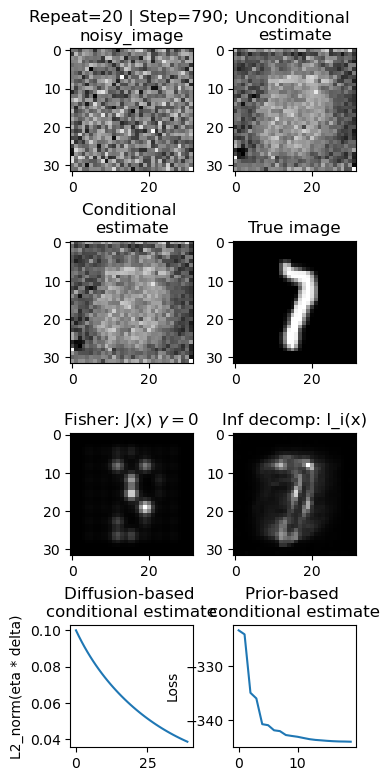

In [7]:
# set plot
fig, ax = plt.subplots(4,2, figsize=(3,7))

# plot
ax[0,0].imshow(x.cpu(), cmap='gray'); ax[0,0].set_title(f"Repeat={i} | Step={t[j]}; \nnoisy_image")
ax[0,1].imshow(xhat.cpu(), cmap='gray'); ax[0,1].set_title("Unconditional \nestimate")
ax[1,0].imshow(xtilde.cpu(), cmap='gray'); ax[1,0].set_title("Conditional \nestimate")
ax[1,1].imshow(xtrue.cpu(), cmap='gray'); ax[1,1].set_title("True image")
ax[2,0].imshow(J0.cpu(), cmap='gray'); ax[2,0].set_title("Fisher: J(x) $\gamma=0$")
ax[2,1].imshow(Inf.cpu(), cmap='gray'); ax[2,1].set_title("Inf decomp: I_i(x)")
ax[3,0].cla()
ax[3,0].plot(tensor(delta_l2_norm).cpu()); ax[3,0].set_title("Diffusion-based \nconditional estimate")
ax[3,0].set_ylabel("L2_norm(eta * delta)")
ax[3,0].set_box_aspect(1)
ax[3,1].cla()
ax[3,1].plot(tensor(loss_history).cpu()); ax[3,1].set_title("Prior-based \nconditional estimate")
ax[3,1].set_ylabel("Loss")
plt.tight_layout(pad=-2, h_pad=1)

## Figure

In [ ]:
# set plot
fig, ax = plt.subplots(1,3, figsize=(3,7))

# plot
ax[0].imshow(xtrue.cpu(), cmap='gray'); ax[1,1].set_title("True image")
ax[1].imshow(J0.cpu(), cmap='gray'); ax[2,0].set_title("Fisher: J(x, $\gamma=0$)")
ax[2].imshow(Inf.cpu(), cmap='gray'); ax[2,1].set_title("$i_{local}(xi)$")
plt.tight_layout(pad=-2, h_pad=1)

# save figure
plt.savefig('figures/zero_shot_ilocal.svg', transparent=True, dpi=400, )

## Control - image 

/tmp/ipykernel_1066975/934271009.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xtrue_ref = torch.load(os.path.join(proj_path, "dataset/02_test/digit.pt"))


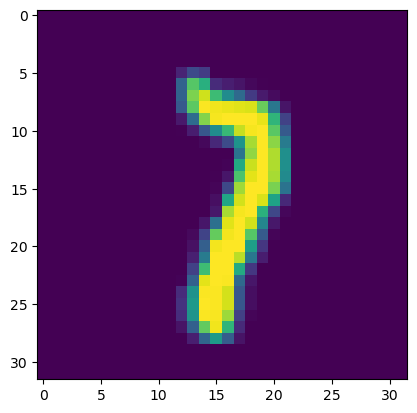

In [ ]:
# set plot
fig, ax = plt.subplots(1,1, figsize=(2,2))

# image
ax.imshow(xtrue.cpu())

# regression test
xtrue_ref = torch.load(os.path.join(proj_path, "dataset/02_test/digit.pt"))
assert (xtrue==xtrue_ref).all(), "digit is wrong, to test the neural model, use the 7 digit initially used."

## Controls - Receptive fields 

_superimposed_

/tmp/ipykernel_1066975/834354265.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  w_ref = torch.load(os.path.join(proj_path, "dataset/02_test/neuron_weights.pt")) # weig

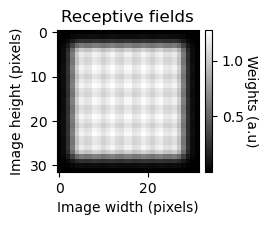

In [ ]:
# set plot
fig, ax = plt.subplots(1,1, figsize=(2,2))

# superimpose receptive fields
rf_all = zeros(32, 32)
for n_i in range(w.shape[1]):
    rf_all += w[:,n_i].reshape(32,32).T

# plot neurons' receptive fields
im = ax.imshow(rf_all.cpu(), cmap="gray");
ax.set_xlabel("Image width (pixels)")
ax.set_ylabel("Image height (pixels)")
ax.set_title("Receptive fields")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Weights (a.u)', rotation=270, labelpad=10)

# regression-test
w_ref = torch.load(os.path.join(proj_path, "dataset/02_test/neuron_weights.pt")) # weights to match
assert (w == w_ref).all(), "weights are wrong"

## Controls - neural responses

* Expected: responses for this digit must be identical to those produced by the neural model used to train the conditional DDPM model

In [ ]:
# report firing rates, responses
print("neural responses (average firing rate):", ffun(vec(xtrue)).squeeze())
print("neural responses (spike count):", response.squeeze())
print("shape:", response.shape)

# regression-testing data
firing_rate_ref = torch.load(os.path.join(proj_path, "dataset/02_test/neuron_firing_rate.pt"))
spike_count_ref = torch.load(os.path.join(proj_path, "dataset/02_test/neuron_spike_count.pt"))

# test
assert torch.allclose(ffun(vec(xtrue)).squeeze(), firing_rate_ref, atol=1e-4), "firing rates are wrong"
assert torch.allclose(response.squeeze(), spike_count_ref, atol=1e-4), "spike counts are wrong"

neural responses (average firing rate): tensor([ 0.1745,  0.1792,  0.6819,  0.7758,  0.2563,  0.1781,  0.1745,  0.1742,
         0.1822,  3.1402, 37.1629, 27.1013,  0.3234,  0.1744,  0.1741,  0.1743,
         0.2354,  4.9928, 38.8034,  0.7286,  0.1749,  0.1741,  0.1738,  0.1913,
         9.4390, 37.6587,  0.4614,  0.1746,  0.1741,  0.1742,  0.3667, 36.5675,
        10.9358,  0.1988,  0.1742,  0.1741,  0.1771,  1.6737, 38.5364,  0.8343,
         0.1758,  0.1741,  0.1745,  0.1789,  1.9467, 30.8941,  0.3195,  0.1744,
         0.1745], device='cuda:0')
neural responses (spike count): tensor([ 1.,  0.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0., 39., 28.,  0.,  0.,
         0.,  0.,  0.,  1., 41.,  2.,  0.,  0.,  0.,  0., 14., 36.,  0.,  0.,
         0.,  1.,  0., 46.,  8.,  0.,  0.,  0.,  0.,  3., 30.,  0.,  0.,  0.,
         1.,  0.,  0., 28.,  0.,  0.,  0.], device='cuda:0')
shape: torch.Size([49, 1])


/tmp/ipykernel_1066975/1246047890.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  firing_rate_ref = torch.load(os.path.join(proj_path, "dataset/02_test/neuron_firing_rat